In [1]:
import os
import jax
jax.config.update('jax_enable_x64',True)
from pathlib import Path

from jsindy.sindy_model import JSINDyModel
from jsindy.trajectory_model import DataAdaptedRKHSInterpolant,CholDataAdaptedRKHSInterpolant
from jsindy.dynamics_model import FeatureLinearModel
from jsindy.optim import AlternatingActiveSetLMSolver, LMSettings
from jsindy.optim.solvers.alt_active_set_lm_solver import pySindySparsifier
from pysindy import STLSQ,SSR,MIOSR
from exp.expdata import ExpData, LorenzExp
from exp.metrics import coeff_metrics, data_metrics
import pickle
import jax.numpy as jnp
import time
import matplotlib.pyplot as plt

In [2]:
def legendre_nodes_weights(n,a,b):
    from numpy.polynomial.legendre import leggauss
    nodes,weights = leggauss(n)
    nodes = jnp.array(nodes)
    weights = jnp.array(weights)
    width = b-a
    nodes = (width)/2*nodes + (a+b)/2
    weights = (width/2) * weights
    return nodes,weights

In [8]:
exp_data = LorenzExp
initial_state = jnp.array([ 0.37719066, -0.39631459, 16.92126795])
dt = 0.2
noise_var = 4.
# sigma^2 - var
true_sigma2 = noise_var
t0=0
t1=10.1
n_train = len(jnp.arange(t0,t1,dt))

n_colloc = 500
expdata = exp_data(
    initial_state=initial_state,
    t0=t0,
    t1=t1,
    dt = 0.01,
    dt_train=dt,
    noise= jnp.sqrt(true_sigma2),
    seed=29,
    n_colloc=n_colloc,
    one_rkey=True,
    feature_names=['x','y','z']
)


trajectory_model = CholDataAdaptedRKHSInterpolant()
dynamics_model = FeatureLinearModel(reg_scaling = 1.)
optsettings = LMSettings(
    max_iter = 1000,
    show_progress=True,
    no_tqdm=False,
    min_alpha = 1e-16,
    init_alpha = 5.,
    print_every = 100,
)
data_weight =  1.
colloc_weight = 50. * n_colloc * 3
sparsifier = pySindySparsifier(
    STLSQ(threshold = 0.25,alpha = 0.1)
    )

# sparsifier = pySindySparsifier(
#     MIOSR(target_sparsity = 7,alpha = 0.1)
#     )


optimizer = AlternatingActiveSetLMSolver(
        beta_reg=0.001,
        solver_settings=optsettings,
        fixed_colloc_weight=colloc_weight,
        fixed_data_weight=data_weight,
        sparsifier = sparsifier
        )

model = JSINDyModel(
    trajectory_model=trajectory_model,
    dynamics_model=dynamics_model,
    optimizer=optimizer,
    feature_names=expdata.feature_names
)

# nodes,weights = legendre_nodes_weights(500,t0,t1)

model.fit(
    expdata.t_train,
    expdata.x_train,
    t_colloc = expdata.t_colloc,
)

metrics = {}

metrics["coeff_mets"]  = coeff_metrics(
    coeff_est = model.theta.T,
    coeff_true = expdata.true_coeff
)

metrics["data_mets"] = data_metrics(
    pred_sim = model.predict(expdata.x_true),
    true = expdata.x_dot
)
metrics['model_params'] = model.params


  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

{'show_progress': True, 'sigma2_est': Array(1.0000003e-08, dtype=float64), 'data_weight': 1.0, 'colloc_weight': 75000.0}
Warm Start


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 0, loss = 2.35e+07, gradnorm = 7.463e+07, alpha = 4.167, improvement_ratio = 0.8034
Iteration 1, loss = 4.783e+06, gradnorm = 3.277e+08, alpha = 4.167, improvement_ratio = 0.7965
Iteration 2, loss = 3.857e+06, gradnorm = 1.517e+08, alpha = 1.108e+04, improvement_ratio = 0.1942
Iteration 3, loss = 1.117e+06, gradnorm = 4.118e+08, alpha = 100.0, improvement_ratio = 0.7105
Iteration 4, loss = 1.753e+05, gradnorm = 1.528e+08, alpha = 83.33, improvement_ratio = 0.8435
Iteration 5, loss = 6.865e+04, gradnorm = 1.172e+08, alpha = 125.0, improvement_ratio = 0.6102
Iteration 100, loss = 242.3, gradnorm = 5.136e+04, alpha = 11.22, improvement_ratio = 0.8003
Iteration 200, loss = 198.5, gradnorm = 2.538e+04, alpha = 0.2926, improvement_ratio = 0.7902
Line Search Failed!
Final Iteration Results
Iteration 278, loss = 193.9, gradnorm = 0.04789, alpha = 2.152e+05, improvement_ratio = -1.525e+05
Model after smooth warm start
(x)' = 28.648 1 + 1.389 x + 2.912 y + -3.657 z + -1.374 x^2 + 2.127

In [9]:
model.print()

(x)' = -9.371 x + 9.734 y
(y)' = 27.977 x + -1.163 y + -0.980 x z
(z)' = -2.662 z + 1.045 x y


In [10]:
model.print(expdata.true_coeff.T)

(x)' = -10.000 x + 10.000 y
(y)' = 28.000 x + -1.000 y + -1.000 x z
(z)' = -2.667 z + 1.000 x y


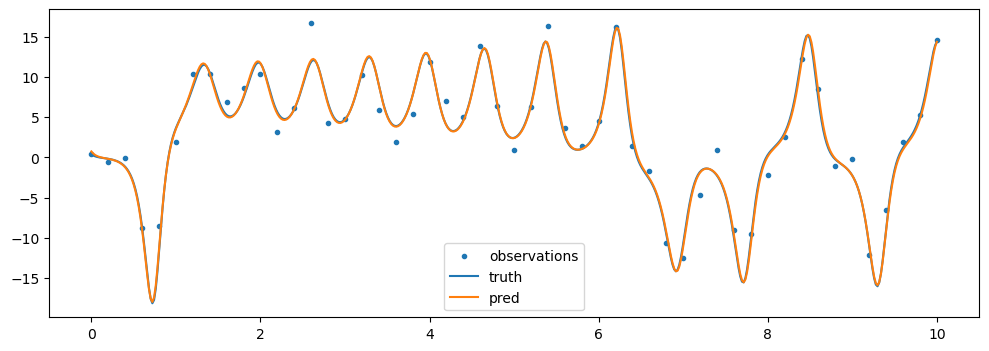

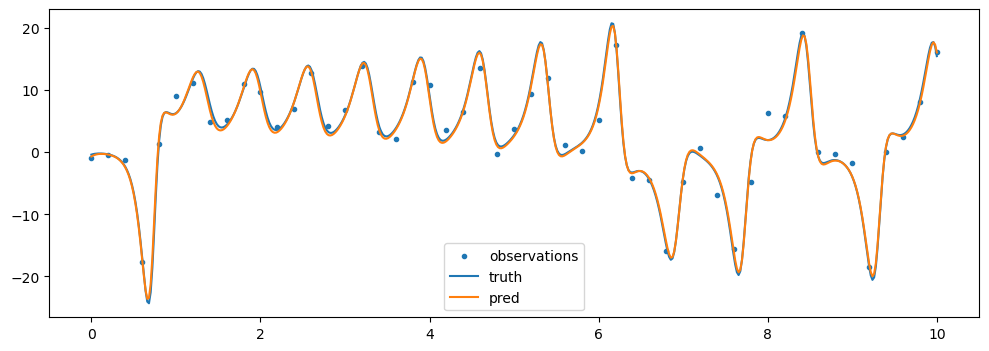

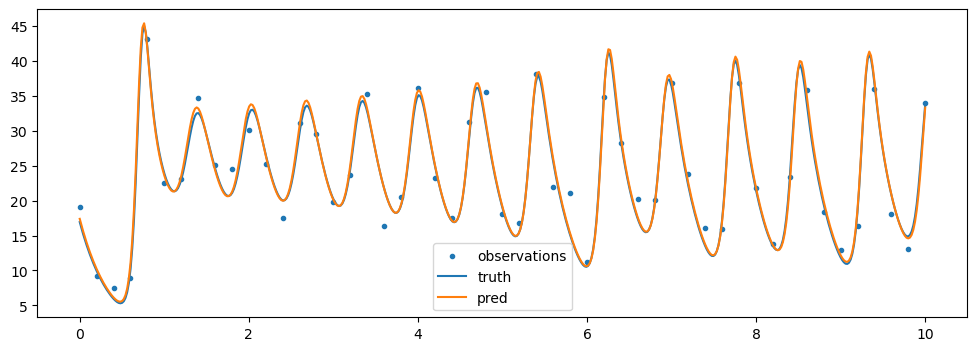

In [11]:
t_grid = jnp.linspace(0,10,500)
state_preds = model.predict_state(t_grid)
true_states = jax.vmap(expdata.system_sol.evaluate)(t_grid)
for dim in range(3):
    plt.figure(figsize=(12,4))
    plt.scatter(expdata.t_train,expdata.x_train[:,dim],label = 'observations',s = 9)
    plt.plot(t_grid,true_states[:,dim],label = 'truth')
    plt.plot(t_grid,state_preds[:,dim],label = 'pred')
    plt.legend()
    plt.show()


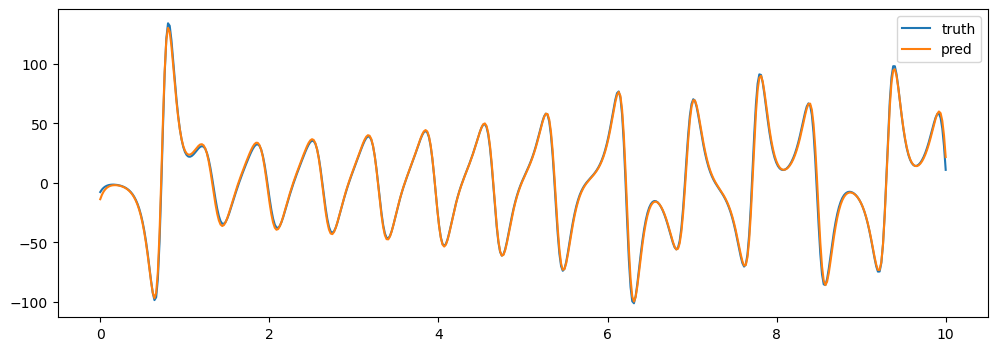

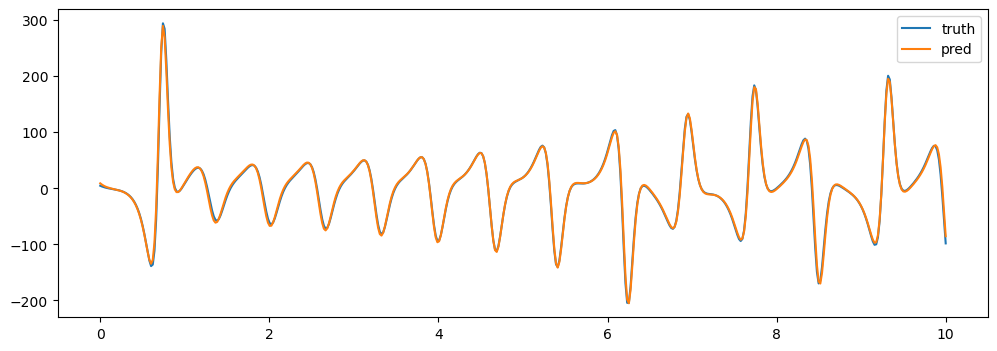

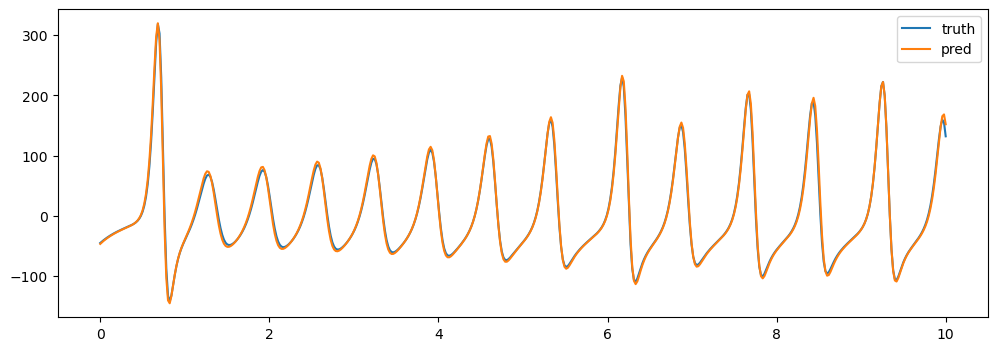

In [12]:
t_grid = jnp.linspace(0,10,500)
dx_preds = model.traj_model.derivative(t_grid,model.z,1)

true_states = jax.vmap(expdata.system_sol.evaluate)(t_grid)
true_dx = model.predict(true_states,expdata.true_coeff.T)
for dim in range(3):
    plt.figure(figsize=(12,4))
    plt.plot(t_grid,true_dx[:,dim],label = 'truth')
    plt.plot(t_grid,dx_preds[:,dim],label = 'pred')
    plt.legend()
    plt.show()


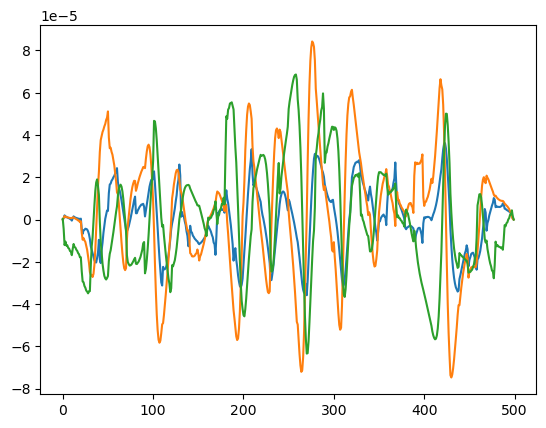

In [13]:
z = model.z
theta = model.theta
plt.plot(model.residuals.colloc_residual(z,theta)[::3])
plt.plot(model.residuals.colloc_residual(z,theta)[1::3])
plt.plot(model.residuals.colloc_residual(z,theta)[2::3])

In [16]:
t_grid = jnp.linspace(0,10,500)

xdot_pred = model.traj_model.derivative(t_grid,model.z)
x_pred = model.predict_state(t_grid)
A = dynamics_model.feature_map(x_pred)

from pysindy import STLSQ,SR3,EnsembleOptimizer,SSR,MIOSR
stlsq = STLSQ(threshold = 0.25,alpha =0.01,unbias = True)
optimizer = stlsq

optimizer = MIOSR(7,alpha = 0.)
# EnsembleOptimizer(
#     stlsq,library_ensemble=True,
#     bagging = True,
#     n_models = 5000,
#     n_candidates_to_drop=2
#     )
# optimizer = SSR(criteria = 'model_residual',kappa = 0.1,alpha = 0.01)
optimizer.fit(A,xdot_pred)
refit_theta = jnp.array(optimizer.coef_).T

model.print(refit_theta)

(x)' = -9.371 x + 9.734 y
(y)' = 27.977 x + -1.163 y + -0.980 x z
(z)' = -2.662 z + 1.045 x y


In [17]:
import diffrax
def model_ode(t,x,args=None):
    return model.predict(x,model.theta)

term = diffrax.ODETerm(model_ode)
solver = diffrax.Tsit5()
save_at = diffrax.SaveAt(ts = t_grid)
pidcontroller = diffrax.PIDController(rtol = 1e-8,atol = 1e-8)
sol = diffrax.diffeqsolve(
    term,
    solver,
    t0=t0,
    t1=t1,
    dt0=0.001, 
    y0=initial_state,
    saveat=save_at,
    max_steps = int(100*(t1-t0)/dt),
    args = None,
    stepsize_controller=pidcontroller
)

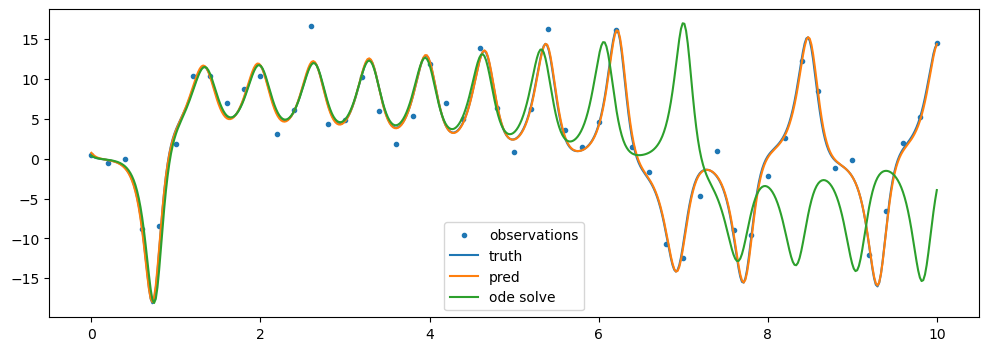

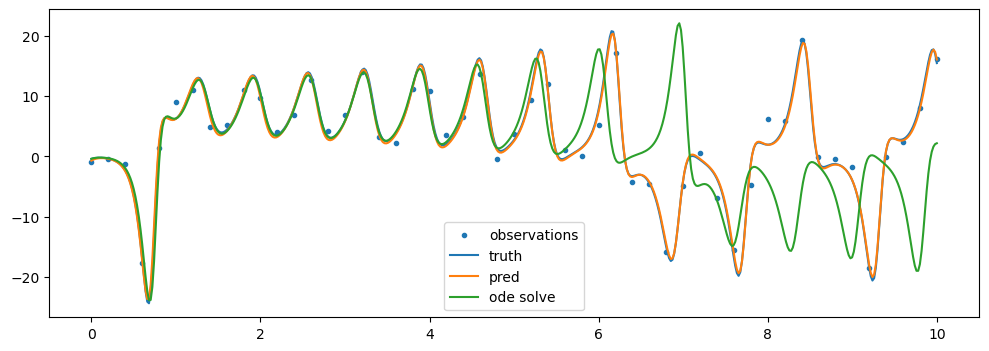

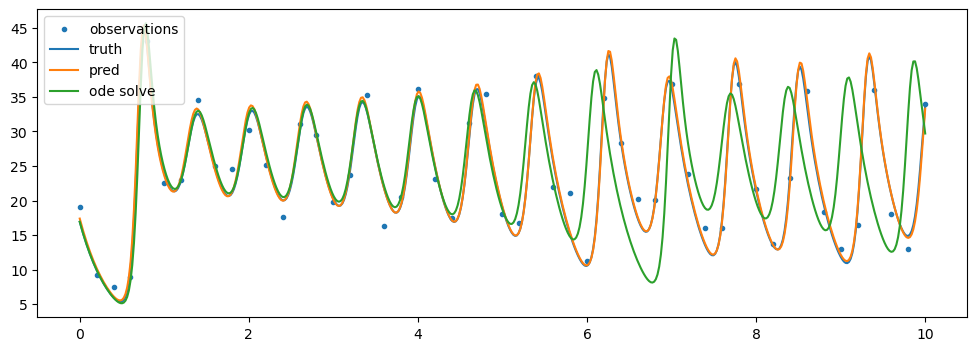

In [18]:
t_grid = jnp.linspace(0,10,500)
state_preds = model.predict_state(t_grid)
true_states = jax.vmap(expdata.system_sol.evaluate)(t_grid)
for dim in range(3):
    plt.figure(figsize=(12,4))
    plt.scatter(expdata.t_train,expdata.x_train[:,dim],label = 'observations',s = 9)
    plt.plot(t_grid,true_states[:,dim],label = 'truth')
    plt.plot(t_grid,state_preds[:,dim],label = 'pred')
    plt.plot(t_grid,sol.ys[:,dim],label = 'ode solve')
    plt.legend()
    plt.show()


Array([[ 0.37719066, -0.39631459, 16.92126795],
       [ 0.21005029, -0.30531131, 16.05438462],
       [ 0.08676406, -0.24653982, 15.23532217],
       ...,
       [12.52338388, 17.78434995, 25.47723535],
       [13.5630861 , 17.75017345, 28.84694303],
       [14.32495527, 16.82424938, 32.22756534]], dtype=float64)

In [37]:
def clenshaw_curtis(n: int, a: float = -1.0, b: float = 1.0):
    """
    Compute Clenshaw–Curtis nodes and weights on [a, b].

    Parameters
    ----------
    n : int
        Number of sub‑intervals (gives n+1 nodes, including the endpoints).
    a, b : float
        Integration interval (a < b).

    Returns
    -------
    x : jax.Array, shape (n+1,)
        Quadrature nodes in ascending order.
    w : jax.Array, shape (n+1,)
        Corresponding quadrature weights.
    """
    k = jnp.arange(n + 1)
    x = jnp.cos(jnp.pi * k / n)                       # nodes on [-1, 1]

    c = jnp.zeros(n + 1)
    c = c.at[0].set(2.0)
    c = c.at[n].set(2.0)
    c = c.at[1:n].set(2.0 / (1.0 - (2 * k[1:n])**2))  # cosine‑series coeffs

    r = jnp.concatenate([c, c[n-1:0:-1]])             # even extension
    f = jnp.real(jnp.fft.ifft(r))                     # cosine transform
    w = jnp.concatenate([jnp.array([f[0]]),
                            2.0 * f[1:n],
                            jnp.array([f[n]])])

    # rescale from [-1,1] to [a,b]
    x = (a + b) / 2.0 + (b - a) / 2.0 * x
    w = (b - a) / 2.0 * w

    return x[::-1],w[::-1]


In [39]:
nodes,weights = clenshaw_curtis(500,0,10)

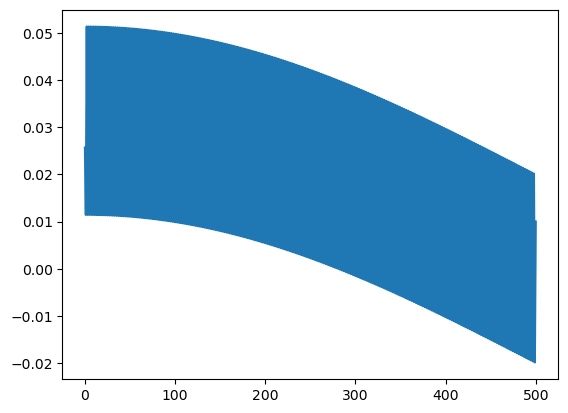

In [43]:
plt.plot(weights)

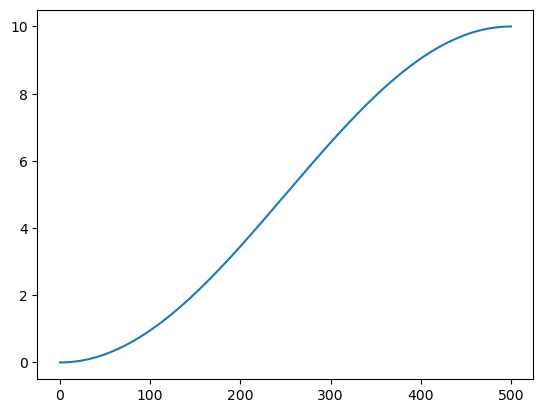

In [42]:
plt.plot(nodes)

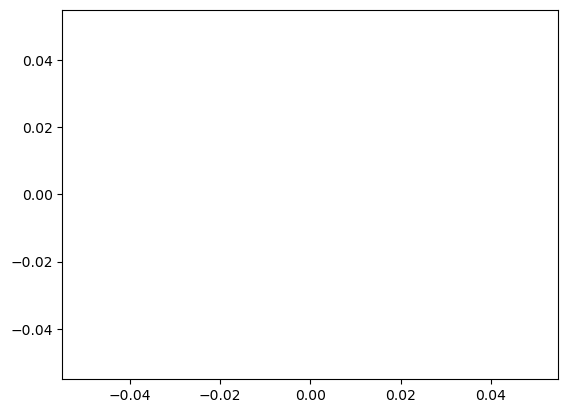

In [31]:
plt.plot(nodes,weights)